In [1]:
import momepy as mm
import numpy as np
import numba
import geopandas as gpd
import pandas as pd
import shapely
from fast_hdbscan.numba_kdtree import NumbaKDTree, kdtree_to_numba, rdist, point_to_node_lower_bound_rdist
from sklearn.preprocessing import StandardScaler
from collections import namedtuple
from core.cluster_validation import get_linkage_matrix
import umap

In [2]:
data = pd.read_parquet('../data/morphotopes_data_69333_100_3__median_gaussian.pq')
sizes = data.iloc[:, -1]
data = data.iloc[:, :-1]

In [3]:
vals = StandardScaler().fit_transform(data)
component_data = pd.DataFrame(vals, columns=data.columns, index=data.index)
component_data = component_data.drop(component_data.columns[component_data.std() == 0], axis=1)

# component_data = component_data[component_data.index >= 0]
vals = np.nan_to_num(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)

In [4]:
n_neighbors = 10
umap_metric = 'euclidean'

reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=20, 
                    min_dist=0, negative_sample_rate=50, 
                    metric=umap_metric, verbose=True, random_state=1)

embedding = reducer.fit_transform(component_data.values)

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0, n_components=20, n_jobs=1, n_neighbors=10, negative_sample_rate=50, random_state=1, verbose=True)
Thu Oct 10 17:17:22 2024 Construct fuzzy simplicial set
Thu Oct 10 17:17:22 2024 Finding Nearest Neighbors
Thu Oct 10 17:17:22 2024 Building RP forest with 8 trees
Thu Oct 10 17:17:23 2024 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	Stopping threshold met -- exiting after 5 iterations
Thu Oct 10 17:17:27 2024 Finished Nearest Neighbor Search
Thu Oct 10 17:17:28 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Oct 10 17:18:05 2024 Finished embedding


In [5]:
component_data = pd.DataFrame(embedding)

In [6]:
min_cluster_size = 500
sample_weights = sizes.values.astype(np.float32)
allow_single_cluster = False

### weighted hsbcan

In [7]:
from fast_hdbscan.boruvka import parallel_boruvka
from fast_hdbscan.cluster_trees import (mst_to_linkage_tree_w_sample_weights, 
condense_tree, cluster_tree_from_condensed_tree, extract_eom_clusters,
get_cluster_label_vector, bfs_from_hierarchy, eliminate_branch, CondensedTree, score_condensed_tree_nodes, eom_recursion)
from sklearn.neighbors import KDTree

In [8]:
# from fast_hdbscan import fast_hdbscan
# res = fast_hdbscan(component_data.values, sample_weights=sample_weights.astype(np.float32), min_samples=min_cluster_size, min_cluster_size=min_cluster_size , return_trees=True)

In [9]:

## hdbscan kdtree
sklearn_tree = KDTree(component_data.values)
numba_tree = kdtree_to_numba(sklearn_tree)

edges = parallel_boruvka(
    numba_tree,
    min_samples=min_cluster_size,
    sample_weights=sample_weights,
)
sorted_mst = edges[np.argsort(edges.T[2])]

linkage_tree = mst_to_linkage_tree_w_sample_weights(sorted_mst, sample_weights)

In [10]:
### agglomerative clustering tree
def get_linkage_matrix_sizes(model, sizes=None):
    """" Create a linkage matrix from a sklearn hierarchical clustering model.
    Requires the full tree and the distances stored in the model instance.
    If sizes is None, by default every sample has weight 1"""

    if sizes is None:
        sizes = np.ones(model.labels_.shape[0])
    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += sizes[child_idx]  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

In [11]:
# ### agglomerative clustering tree

# linkage = 'ward'
# metric = 'euclidean'
# sklearn_linkage_structure = namedtuple('Model', ['children_', 'labels_', 'distances_'])






# from sklearn.cluster import AgglomerativeClustering
# clusterer = AgglomerativeClustering(linkage=linkage,
#                                     metric=metric,
#                                     compute_full_tree=True,
#                                     compute_distances=True)
# model = clusterer.fit(component_data.values)
# linkage_tree = get_linkage_matrix_sizes(model, sizes=sample_weights)

In [12]:
### tests against hdbscan linkage tree

# m = sklearn_linkage_structure(linkage_tree[:, [0, 1]].astype(int),
#                               np.ones(component_data.shape[0]),
#                               linkage_tree[:, 2])

# l = get_linkage_matrix_sizes(m, sizes=sample_weights)
# assert np.allclose(l, linkage_tree)

# l1 = get_linkage_matrix(model)
# l2 = get_linkage_matrix_sizes(model)
# assert np.allclose(l1, l2)

In [13]:
@numba.njit(fastmath=True)
def condense_tree(hierarchy, min_cluster_size=10, bandwidth=1, sample_weights=None):
    root = 2 * hierarchy.shape[0]
    num_points = hierarchy.shape[0] + 1
    next_label = num_points + 1

    node_list = bfs_from_hierarchy(hierarchy, root, num_points)

    relabel = np.zeros(root + 1, dtype=np.int64)
    relabel[root] = num_points

    parents = np.ones(root, dtype=np.int64)
    children = np.empty(root, dtype=np.int64)
    lambdas = np.empty(root, dtype=np.float32)
    sizes = np.ones(root, dtype=np.int64)

    ignore = np.zeros(root + 1, dtype=np.bool_) # 'bool' is no longer an attribute of 'numpy'

    if sample_weights is None:
        sample_weights = np.ones(num_points, dtype=np.float32)

    idx = 0

    for node in node_list:
        if ignore[node] or node < num_points:
            continue

        parent_node = relabel[node]
        l, r, d, _ = hierarchy[node - num_points]
        left = np.int64(l)
        right = np.int64(r)
        if d > 0.0:
            # gaussian lambda value
            lambda_value = np.exp(-(((d / bandwidth) / 2) ** 2)) / (np.sqrt(2) * np.pi)
            # lambda_value = 1.0 / d
        else:
            lambda_value = np.inf

        left_count = np.int64(hierarchy[left - num_points, 3]) if left >= num_points else sample_weights[left]
        right_count = np.int64(hierarchy[right - num_points, 3]) if right >= num_points else sample_weights[right]

        # The logic here is in a strange order, but it has non-trivial performance gains ...
        # The most common case by far is a singleton on the left; and cluster on the right take care of this separately
        if left < num_points and right_count >= min_cluster_size:
            relabel[right] = parent_node
            parents[idx] = parent_node
            children[idx] = left
            lambdas[idx] = lambda_value
            idx += 1
        # Next most common is a small left cluster and a large right cluster: relabel the right node; eliminate the left branch
        elif left_count < min_cluster_size and right_count >= min_cluster_size:
            relabel[right] = parent_node
            idx = eliminate_branch(left, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
        # Then we have a large left cluster and a small right cluster: relabel the left node; elimiate the right branch
        elif left_count >= min_cluster_size and right_count < min_cluster_size:
            relabel[left] = parent_node
            idx = eliminate_branch(right, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
        # If both clusters are small then eliminate all branches
        elif left_count < min_cluster_size and right_count < min_cluster_size:
            idx = eliminate_branch(left, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
            idx = eliminate_branch(right, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
        # and finally if we actually have a legitimate cluster split, handle that correctly
        else:
            relabel[left] = next_label

            parents[idx] = parent_node
            children[idx] = next_label
            lambdas[idx] = lambda_value
            sizes[idx] = left_count
            next_label += 1
            idx += 1

            relabel[right] = next_label

            parents[idx] = parent_node
            children[idx] = next_label
            lambdas[idx] = lambda_value
            sizes[idx] = right_count
            next_label += 1
            idx += 1

    return CondensedTree(parents[:idx], children[:idx], lambdas[:idx], sizes[:idx])

In [14]:
from scipy.stats import gaussian_kde
e = gaussian_kde(sorted_mst[:, 2])
f = e.covariance_factor()
bw = f * linkage_tree[:, 2].std()
bw

np.float64(0.1183077524000268)

In [15]:
condensed_tree = condense_tree(linkage_tree, 
                               min_cluster_size=min_cluster_size,
                               bandwidth=.12,
                               sample_weights=sample_weights)

In [16]:
cluster_tree = cluster_tree_from_condensed_tree(condensed_tree)

In [17]:
@numba.njit()
def score_condensed_tree_nodes(condensed_tree):
    result = {0: np.float64(0.0) for i in range(0)}

    for i in range(condensed_tree.parent.shape[0]):
        parent = condensed_tree.parent[i]
        if parent in result:
            result[parent] += condensed_tree.lambda_val[i] * condensed_tree.child_size[i]
        else:
            result[parent] = condensed_tree.lambda_val[i] * condensed_tree.child_size[i]

        if condensed_tree.child_size[i] > 1:
            child = condensed_tree.child[i]
            if child in result:
                result[child] -= condensed_tree.lambda_val[i] * condensed_tree.child_size[i]
            else:
                result[child] = -condensed_tree.lambda_val[i] * condensed_tree.child_size[i]

    return result

@numba.njit()
def extract_eom_clusters(condensed_tree, cluster_tree, allow_single_cluster=False):
    node_scores = score_condensed_tree_nodes(condensed_tree)
    selected_clusters = {node: False for node in node_scores}

    if len(cluster_tree.parent) == 0:
        return np.zeros(0, dtype=np.int64)

    cluster_tree_root = cluster_tree.parent.min()

    if allow_single_cluster:
        eom_recursion(cluster_tree_root, cluster_tree, node_scores, selected_clusters)
    elif len(node_scores) > 1:
        root_children = cluster_tree.child[cluster_tree.parent == cluster_tree_root]
        for child_node in root_children:
            eom_recursion(child_node, cluster_tree, node_scores, selected_clusters)

    return np.asarray([node for node, selected in selected_clusters.items() if selected])

In [18]:
selected_clusters = extract_eom_clusters(condensed_tree, cluster_tree, allow_single_cluster=allow_single_cluster)
clusters = get_cluster_label_vector(
        condensed_tree,
        selected_clusters,
        0,
        n_samples=data.shape[0],
    )
pd.Series(clusters).value_counts()

-1     1723
 15     354
 18     161
 17     140
 11     105
       ... 
 72       5
 24       4
 65       4
 9        4
 40       4
Name: count, Length: 80, dtype: int64

In [19]:
morphotopes = gpd.read_parquet('../data/morphotopes_69333_100_3__median_gaussian.pq')

In [20]:
morphotopes['cluster'] = clusters

In [158]:
# layer.get_fill_color = get_color(morphotopes.cluster)

In [21]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(morphotopes, opacity=.08)

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 235 ms, sys: 39 ms, total: 274 ms
Wall time: 273 ms


In [22]:
from sidecar import Sidecar
sc = Sidecar(title='Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

In [23]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(morphotopes.cluster)

### Tree plotting

In [284]:
# ct_raw = np.rec.fromarrays((ct[0], ct[1], ct[2], ct[3]),
#          dtype=[(' parent', np.intp),('child', np.intp),('lambda_val', float),('child_size', np.intp)])

In [26]:
from hdbscan.plots import SingleLinkageTree
import matplotlib.pyplot as plt

<Axes: ylabel='distance'>

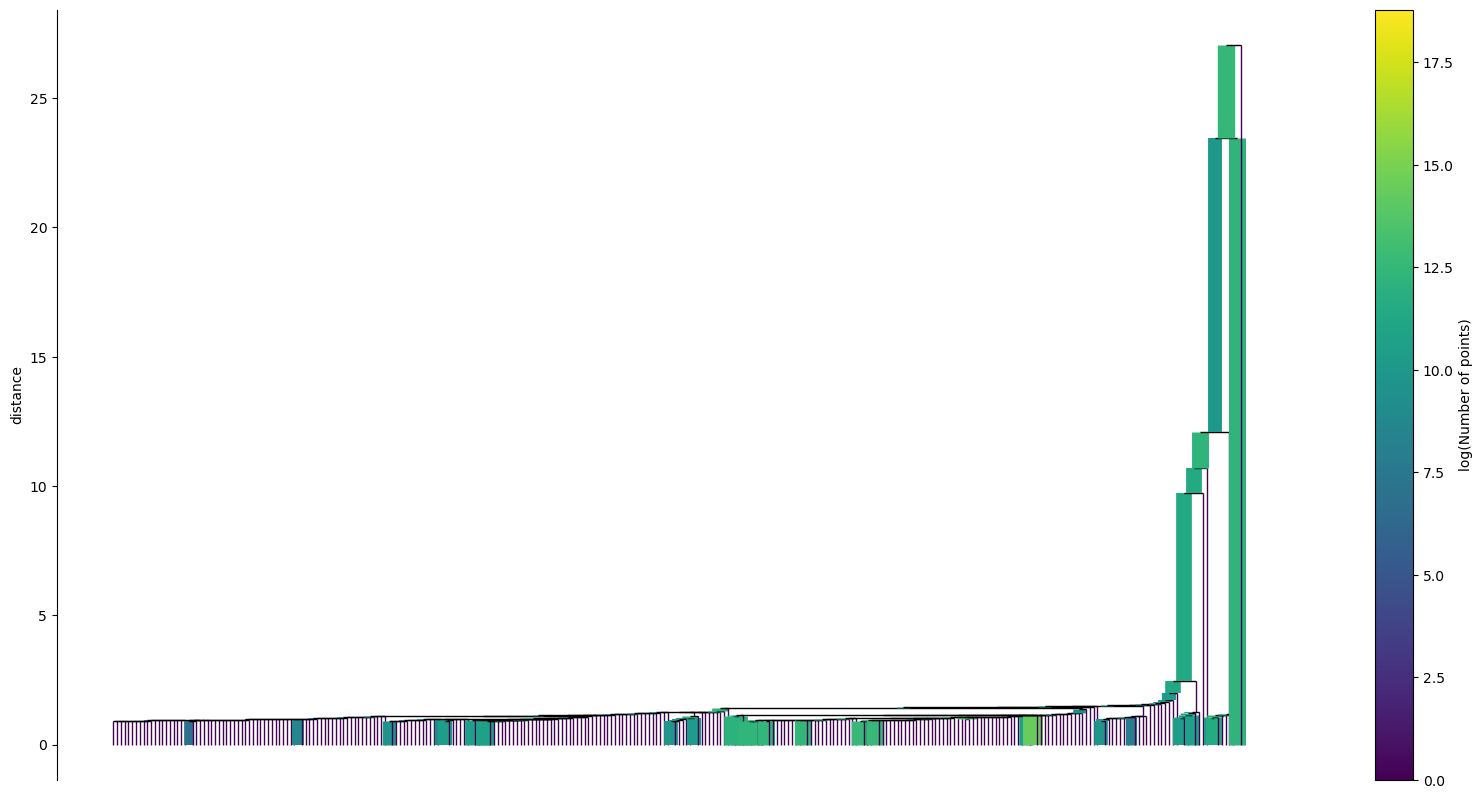

In [31]:
fig, ax = plt.subplots(figsize=(20,10))
SingleLinkageTree(linkage_tree).plot(axis=ax, truncate_mode='lastp', p=300)